# Operator notebook
This notebook is used to examine numerical errors in the implementation of the Blagovestchenskii operators $P_r$, $B$, $J$ and $K$.

In [1]:
import sys

sys.path.append("../")
import numpy as np
from src.ITRC import ITRC
import src.simulation as simulation
from functools import partial
import matplotlib.pyplot as plt

# Parameters
L = 2.5
n_x = 200
dt = 0.01
solver_scale = 5  # The denser forward problem mesh size is scaled using this
T = 2.5
alpha = 10 ** (-3)  # Regularization parameter

# Simulation
c = lambda x: 1
Lambda, dense_t_mesh = simulation.simulate_Lambda(
    c=c, dt=dt, T=T, L=L, solver_scale=solver_scale, cmax=1
)

# Create ITRC object
ITRC = ITRC(L, n_x, T, dense_t_mesh[0::solver_scale], Lambda)

In this section, we study the integral operators used in the regularization scheme. We plot the results and errors of the numerical operators
on simple input functions.

We first define the input, then the analytical results of applying the operators.

In [2]:
f = lambda t: t
g = lambda t: -t


def Bg(t):
    cells = simulation.cell_condlist(t, cells=[0, ITRC.T])

    def part(t):
        return 0.5 * t**2 - 0.5 * ITRC.T**2

    vals = [part]
    return np.piecewise(t, cells, vals)


calc_Bg = ITRC.oper_B(g(ITRC.t_mesh))
func_Bg = Bg(ITRC.t_mesh)


def Jg(t):
    cells = simulation.cell_condlist(t, cells=[0, ITRC.T])

    def part(t):
        return ITRC.T * t - ITRC.T**2

    vals = [part]
    return np.piecewise(t, cells, vals)


calc_Jg = ITRC.oper_J(g(ITRC.t_mesh))
func_Jg = Jg(ITRC.t_mesh)


def Lambda_g(t):
    return -(1 / 2) * t**2


calc_Lambda_g = ITRC.Lambda @ g(ITRC.t_mesh)
func_Lambda_g = Lambda_g(ITRC.t_mesh)


def Kg(t):
    cells = simulation.cell_condlist(t, cells=[0, ITRC.T])

    def part(t):
        return -(1 / 6) * (-(t**3) + ITRC.T**3)  # Flipped sign

    vals = [part]
    return np.piecewise(t, cells, vals)


calc_Kg = ITRC.oper_K(g(ITRC.t_mesh), ITRC.Lambda)
func_Kg = Kg(ITRC.t_mesh)

We first plot the impulse `g` used by our test cases:

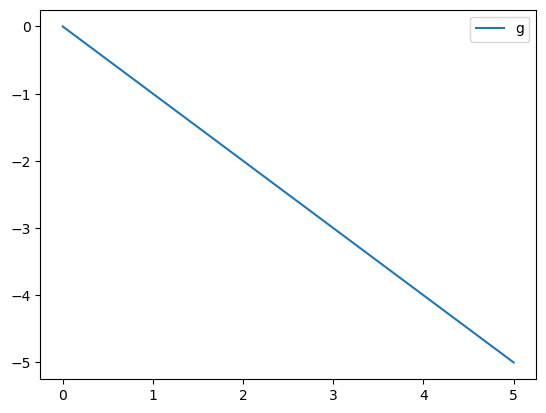

In [3]:
plt.plot(ITRC.t_mesh, g(ITRC.t_mesh), label="g")
plt.legend()

In [4]:
r = ITRC.dt  # / 2
rad = 1 - 10 ** (-16)
h0 = partial(simulation.bump, a=-r, b=r, radius=rad * r, deg=3)
h_list = []
h_list = list(map(lambda t: lambda x: h0(x - t), ITRC.t_mesh))


@np.vectorize
def g_interp(x):
    """Computes g as a sum of the basis bump functions"""
    return sum(g(x) * h(x) for h in h_list)


g_interp_arr = g_interp(dense_t_mesh)

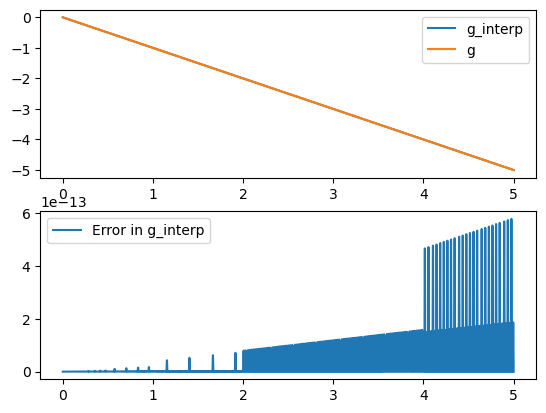

In [5]:
inds = range(2)
fig, axs = plt.subplots(2, 1)
g_arr = g(dense_t_mesh)
axs[0].plot(dense_t_mesh, g_interp_arr, label="g_interp")
axs[0].plot(dense_t_mesh, g_arr, label="g")
axs[1].plot(dense_t_mesh, np.abs(g_interp_arr - g_arr), label="Error in g_interp")
for ax in axs:
    ax.legend()

The following plots compare the numerical operation of `ITRC.oper_B` on `g` (denoted `calc_Bg`) with the analytical solution `func_Bg`. We also examine the difference of the solutions. 

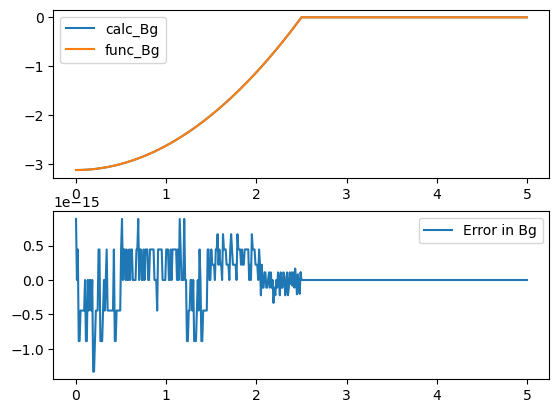

In [6]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(ITRC.t_mesh, calc_Bg, label="calc_Bg")
axs[0].plot(ITRC.t_mesh, func_Bg, label="func_Bg")
axs[1].plot(ITRC.t_mesh, calc_Bg - func_Bg, label="Error in Bg")

for ax in axs:
    ax.legend()

We draw similar plots for the operator `ITRC.oper_J`:

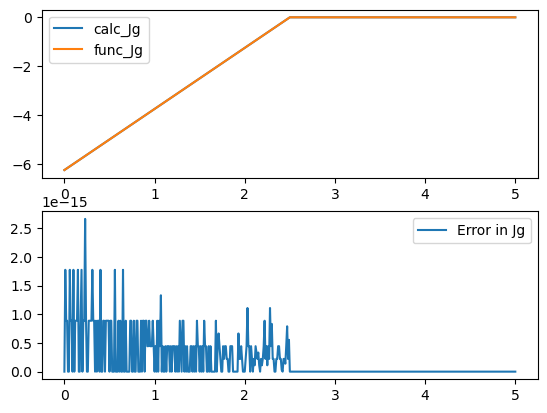

In [7]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(ITRC.t_mesh, calc_Jg, label="calc_Jg")
axs[0].plot(ITRC.t_mesh, func_Jg, label="func_Jg")
axs[1].plot(ITRC.t_mesh, np.abs(calc_Jg - func_Jg), label="Error in Jg")

for ax in axs:
    ax.legend()

Before plotting results for `ITRC.oper_K`, we note that the function uses the computed Neumann-to-Dirichlet matrix $\Lambda$.
We plot the action of $\Lambda$ on $g$:

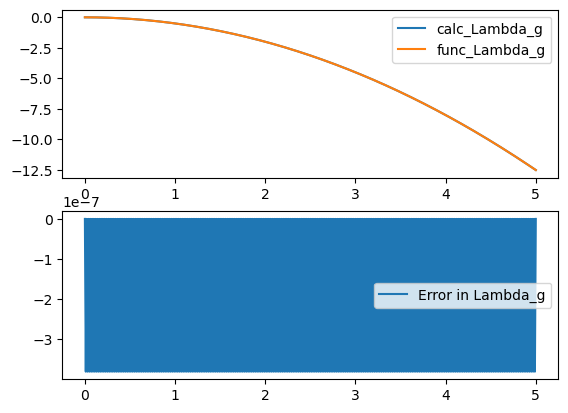

In [8]:
fig, axs = plt.subplots(2, 1)
coef_arr = np.ones(ITRC.t_mesh.shape)
adj_Lambda = ITRC.Lambda * coef_arr
adj_Lambda_g = adj_Lambda @ g(ITRC.t_mesh)
axs[0].plot(ITRC.t_mesh, adj_Lambda_g, label="calc_Lambda_g")
axs[0].plot(ITRC.t_mesh, func_Lambda_g, label="func_Lambda_g")
axs[1].plot(ITRC.t_mesh, adj_Lambda_g - func_Lambda_g, label="Error in Lambda_g")

for ax in axs:
    ax.legend()

We also calculate $\Lambda g$ using the solver, for comparison:

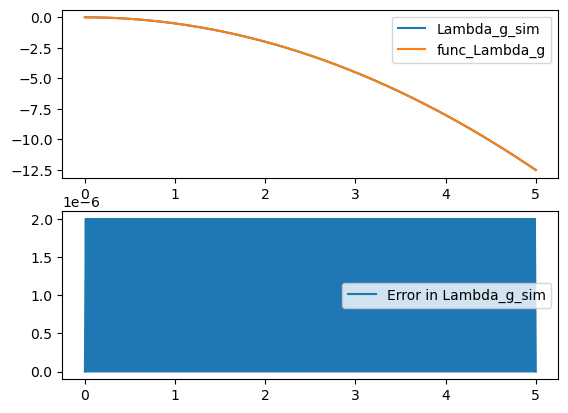

In [9]:
Lambda_g_sim, ts_g, xs_g = simulation.compute_Lambda_h(
    c=c, dt=ITRC.dt, T=2 * T, L=L, h0=f, cmax=1, solver_scale=solver_scale
)  # f = -g
ts_g = ts_g[::solver_scale]
fig, axs = plt.subplots(2, 1)
axs[0].plot(ts_g, Lambda_g_sim, label="Lambda_g_sim")
axs[0].plot(ts_g, Lambda_g(ts_g), label="func_Lambda_g")
axs[1].plot(ts_g, np.abs(Lambda_g_sim - Lambda_g(ts_g)), label="Error in Lambda_g_sim")
for ax in axs:
    ax.legend()

Finally, we form the plots for `ITRC.oper_K`:

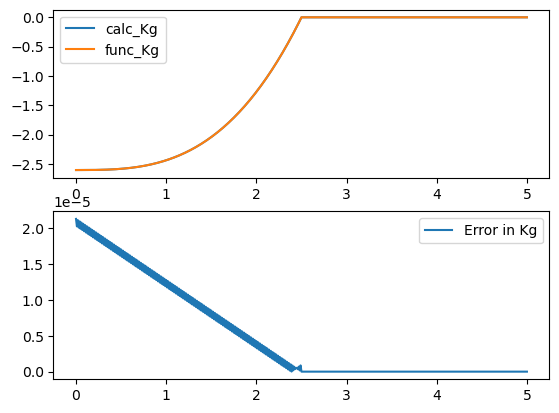

In [10]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(ITRC.t_mesh, calc_Kg, label="calc_Kg")
axs[0].plot(ITRC.t_mesh, func_Kg, label="func_Kg")
axs[1].plot(ITRC.t_mesh, np.abs(calc_Kg - func_Kg), label="Error in Kg")

for ax in axs:
    ax.legend()

As seen in the above plot, there is a small but nontrivial error in K. In practice, the effects of the error disappear in regularization with a large enough $\alpha_{\text{Vol}}$: See `CG_analysis.ipynb`. To conclude, we plot the terms of $K$ separately:

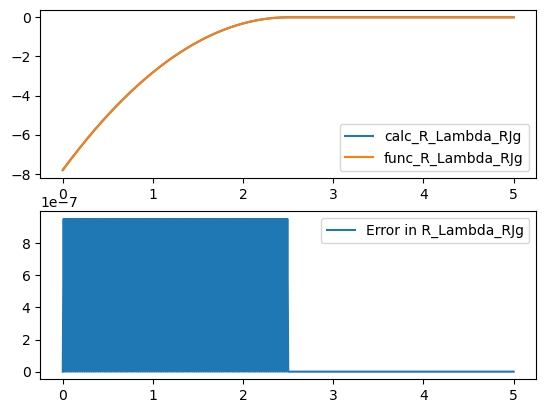

In [11]:
def R_Lambda_RJg(t):
    T = ITRC.T
    cells = simulation.cell_condlist(t, cells=[0, T])

    def part(t):
        return -(0.5 * T * t**2 - T**2 * t + 0.5 * T**3)

    vals = [part]
    return np.piecewise(t, cells, vals)


calc_R_Lambda_RJg = ITRC.oper_R(Lambda @ ITRC.oper_R(ITRC.oper_J(g(ITRC.t_mesh))))
fig, axs = plt.subplots(2, 1)
axs[0].plot(ITRC.t_mesh, calc_R_Lambda_RJg, label="calc_R_Lambda_RJg")
axs[0].plot(ITRC.t_mesh, R_Lambda_RJg(ITRC.t_mesh), label="func_R_Lambda_RJg")
axs[1].plot(
    ITRC.t_mesh,
    np.abs(calc_R_Lambda_RJg - R_Lambda_RJg(ITRC.t_mesh)),
    label="Error in R_Lambda_RJg",
)
for ax in axs:
    ax.legend()

-10.354312250000001


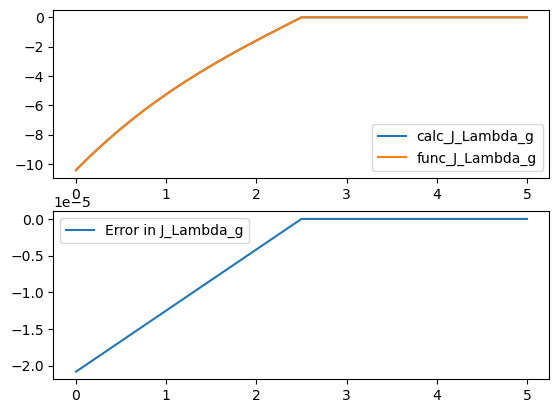

In [12]:
def J_Lambda_g(t):
    T = ITRC.T
    cells = simulation.cell_condlist(t, cells=[0, T])

    def part(t):
        return -1 / 12 * (8 * T**3 - 12 * T**2 * t + 6 * T * t**2 - 2 * t**3)

    vals = [part]
    return np.piecewise(t, cells, vals)


def callback_J(ret, t, f):
    print(ret[1])
    return True


# calc_J_Lambda_g = ITRC.oper_J(Lambda @ g(ITRC.t_mesh), callback=callback_J, max_calls=1)
calc_J_Lambda_g = ITRC.oper_J(func_Lambda_g, callback=callback_J, max_calls=1)
fig, axs = plt.subplots(2, 1)
axs[0].plot(ITRC.t_mesh, calc_J_Lambda_g, label="calc_J_Lambda_g")
axs[0].plot(ITRC.t_mesh, J_Lambda_g(ITRC.t_mesh), label="func_J_Lambda_g")
axs[1].plot(
    ITRC.t_mesh,
    calc_J_Lambda_g - J_Lambda_g(ITRC.t_mesh),
    label="Error in J_Lambda_g",
)
for ax in axs:
    ax.legend()

We conclude that the dominant source of error in $Kg$ is the term $J \Lambda g$. It appears that the composition $J \Lambda$
amplifies errors more than $R \Lambda R J$ in our implementation.